This is all the code for the Linear Algebra pre-lecture 

In [8]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [9]:
#@title Figure settings
import ipywidgets as widgets  # interactive display
from ipywidgets import fixed
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [10]:
# @title Plotting functions
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


def visualize_vectors(v, v_unit):
  """ Plots a 2D vector and the corresponding unit vector

  Args:
    v (ndarray): array of size (2,) with the vector coordinates
    v_unit (ndarray): array of size (2, ) with the unit vector coordinates

  """
  fig, ax = plt.subplots()

  # Set up plot aesthetics
  ax.spines['top'].set_color('none')
  ax.spines['bottom'].set_position('zero')
  ax.spines['left'].set_position('zero')
  ax.spines['right'].set_color('none')
  ax.set(xlim = [-6, 6], ylim = [-6, 6])
  ax.grid(True, alpha=.4, linewidth=1, zorder=0)

  # Plot vectors
  v_arr = ax.arrow(0, 0, v[0], v[1], width=0.08, color='#648FFF',
                   length_includes_head=True, zorder=2);
  v_unit_arr = ax.arrow(0, 0, v_unit[0], v_unit[1], width=0.08,
                        color='#DC267F',
                        length_includes_head=True, zorder=3);
  ax.set(xlim = [-4, 4], ylim = [-4, 4]);

  # Add legend
  leg = ax.legend([v_arr, v_unit_arr],
                  [r"Vector $\mathbf{v}$",
                   r"Normalized vector $\tilde{\mathbf{v}}$"],
                  handlelength=0, fontsize=20, loc='upper left')
  for handle, label in zip(leg.legendHandles, leg.texts):
    label.set_color(handle.get_facecolor())
    handle.set_visible(False)

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
      FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
      self._verts3d = xs, ys, zs

    def draw(self, renderer):
      xs3d, ys3d, zs3d = self._verts3d
      xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
      self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
      FancyArrowPatch.draw(self, renderer)

    def do_3d_projection(self, renderer=None):
      xs3d, ys3d, zs3d = self._verts3d
      xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
      self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

1.1 Vectors 

In this exercise, you will first create the below vector, v, using a numpy array. You will then implement a function, normalize_vector, that outputs a normalized version of the input vector (by dividing each component by the vector length). You will then visualize both the original vector and the unit vector.

AttributeError: 'Legend' object has no attribute 'legendHandles'

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
fin

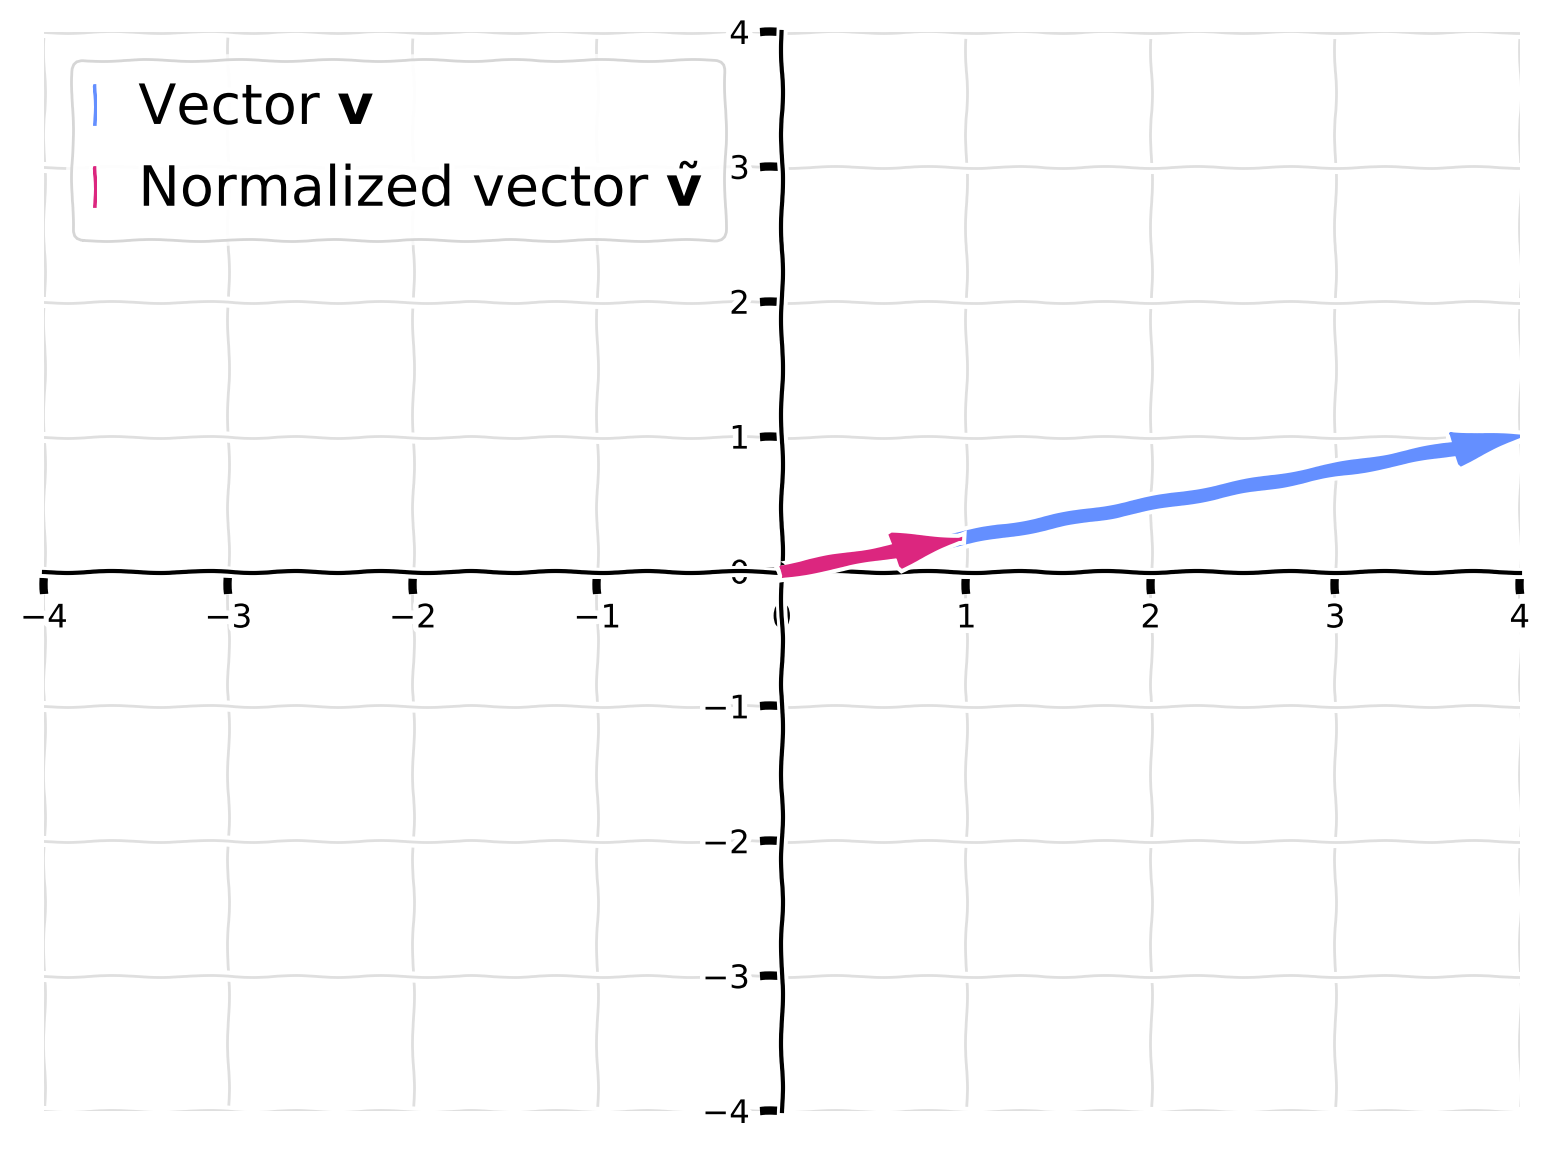

In [12]:
def normalize_vector(input_vector):
  """ Normalizes a vector to length 1

  Inputs:
    input_vector (ndarray): array of shape (n_dim, ) where n_dim is the
        dimensionality of the vector

  Outputs:
    (ndarray): normalized vector of length 1
  """

  #################################################################################
  ## TODO for students: complete normalize_vector function ##
  # Fill out function and remove
  #raise NotImplementedError("Student exercise: complete normalize_vector function")
  #################################################################################

  # Compute vector length (use np.linalg.norm)
  vector_length = np.linalg.norm(input_vector)

  # Create normalized vector
  normalized_vector = input_vector / vector_length

  return normalized_vector

# Create vector v from above (use np.array)
v = np.array([4,1])

# Call the function
v_unit = normalize_vector(v)

# Visualize the vectors
with plt.xkcd():
  visualize_vectors(v, v_unit)

linear combination 